# Spatial Structure of In-connection Density
Written by J. Alexander Bae (jabae@princeton.edu)
- Related to Figure S7

In [9]:
import numpy as np
import pandas as pd

import datajoint as dj

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits import mplot3d
import seaborn as sns

import statsmodels.api as sm

from lib.utils import *
from lib.datajoint import *

%matplotlib inline

## Functions

In [2]:
def plot_spatial_ax(ax, xval, yval, nbins=5, xlab="", ylab="In-conn. density ($\mu m^{-1}$)"):
    
    bins = np.linspace(xval.min(), xval.max()*1.001, nbins)
    
    Xval = sm.add_constant(xval)
    re = sm.OLS(yval, Xval).fit()

    xrng = np.max(xval) - np.min(xval)
    xlin = np.linspace(np.min(xval)-0.05*xrng,np.max(xval)+0.05*xrng,10)
    Xlin = sm.add_constant(xlin)
    dt = re.get_prediction(Xlin).summary_frame(alpha = 0.2)

    ax.plot(xval, yval, 'k.', alpha=0.2)
    ax.fill_between(
        xlin, dt["obs_ci_lower"], dt["obs_ci_upper"],
        alpha=0.2, color="gray")
    ylim = ax.get_ylim()
    ax.vlines(bins, ylim[0], ylim[1], "k", linestyles="--", linewidth=0.5)
    
    ax.set_xlim([xlin.min(), xlin.max()])
    ax.set_ylim(ylim)
    
    ax.set_xlabel(xlab, fontsize=20, fontname="Helvetica")
    ax.set_ylabel(ylab, fontsize=20, fontname="Helvetica")
    ax.set_yticks(np.arange(0,0.009,0.002))
    ax.set_xticklabels(ax.get_xticks().astype("int"), fontsize=15, fontname="Helvetica")
    ax.set_yticklabels(np.round(np.arange(0,0.009,0.002),3), fontsize=15, fontname="Helvetica")
    
    
def draw_cube(ax, x, y, z):
    
    for i in range(2):
        for j in range(2):
            ax.plot(x, (y[i],y[i]), (z[j],z[j]), "k-")

    for i in range(2):
        for j in range(2):
            ax.plot((x[i],x[i]), y, (z[j],z[j]), "k-")

    for i in range(2):
        for j in range(2):
            ax.plot((x[i],x[i]), (y[j],y[j]), z, "k-")

## Connect to DataJoint database
- You need to be registered to access the database. Please refer to README in the repository for registration.

In [6]:
dj.config["database.host"] = "datajoint.ninai.org"
dj.conn()

pinky = dj.create_virtual_module("seung_pinky", "seung_pinky")

Please enter DataJoint username: jabae
Please enter DataJoint password: ········
Connecting jabae@datajoint.ninai.org:3306


## All pyramidal cells (PyCs)

In [7]:
key = {"segmentation": 185}
pyc_list = (pinky.Neuron() & key).fetch("segment_id")
n_pyc = pyc_list.shape[0]

## PyC with functional data

In [12]:
cell_info_func = pd.read_csv("data/cell_functional_info.csv")

pyc_func_list = np.array(cell_info_func["segment_id"])
scan_list = np.array(cell_info_func["scan"])
n_func = pyc_func_list.shape[0]

osi_p = np.array(cell_info_func["osi_p"])
dsi_p = np.array(cell_info_func["dsi_p"])

tune_os_idx = osi_p<0.05
tune_ds_idx = dsi_p<0.05
tune_all_idx = tune_os_idx + tune_ds_idx

seg_id_os = pyc_func_list[tune_os_idx]
seg_id_ds = pyc_func_list[tune_ds_idx]
seg_id_tuned = pyc_func_list[tune_all_idx]

cell_info_func

,segment_id,scan,osi,osi_p,dsi,dsi_p
0,648518346349539895,2,1.399790,0.0085,0.360205,0.9077
1,648518346349537860,2,1.791797,0.0000,0.379977,0.7241
2,648518346349538440,2,1.369347,0.0025,0.257158,0.9983
3,648518346349538527,2,1.021334,0.0276,0.972555,0.9746
4,648518346349538209,2,1.863632,0.0000,0.100173,0.9763
...,...,...,...,...,...,...
107,648518346349537741,6,1.266736,0.0568,0.528219,0.9732
108,648518346349537901,6,1.163586,0.1148,1.162096,0.1404
109,648518346349538001,6,1.321359,0.0631,1.324058,0.0638
110,648518346349538251,6,1.436740,0.0139,1.399342,0.0287


## Get soma center coordinates

In [10]:
pyc_soma_loc = np.zeros((n_pyc, 3))
for i in range(n_pyc):
    
    seg_id = pyc_list[i]
    pyc_soma_loc[i,:] = get_soma_loc(pinky, seg_id)

In [13]:
pyc_func_soma_loc = np.zeros((n_func, 3))
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    idx = np.where(pyc_list==seg_id)[0][0]
    pyc_func_soma_loc[i,:] = pyc_soma_loc[idx,:]

## Spatial distribution of in-connection density

In [20]:
inconn_density = np.zeros((n_func,))
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    inconn_density[i] = (pinky.SynDensity() & {"segment_id": seg_id}).fetch1("conn_in_dens")

In [17]:
xloc = pyc_func_soma_loc[tune_all_idx,0]
yloc = pyc_func_soma_loc[tune_all_idx,1]
zloc = pyc_func_soma_loc[tune_all_idx,2]

/Users/jabae/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jabae/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jabae/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


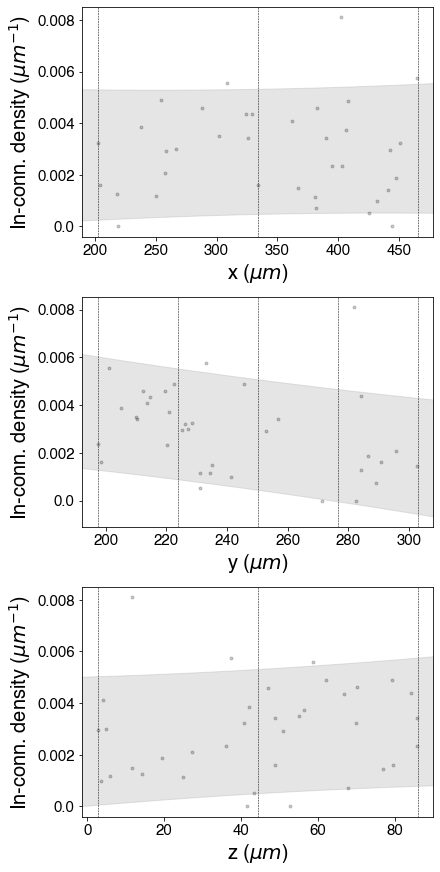

In [21]:
fig = plt.figure(figsize=(6,12), constrained_layout=True)
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])
plot_spatial_ax(ax1, xloc, inconn_density[tune_all_idx], nbins=3, xlab="x ($\mu m$)")
plot_spatial_ax(ax2, yloc, inconn_density[tune_all_idx], nbins=5, xlab="y ($\mu m$)")
plot_spatial_ax(ax3, zloc, inconn_density[tune_all_idx], nbins=3, xlab="z ($\mu m$)")

In [22]:
xloc = pyc_func_soma_loc[tune_all_idx,0]
yloc = pyc_func_soma_loc[tune_all_idx,1]
zloc = pyc_func_soma_loc[tune_all_idx,2]

xbins = np.linspace(np.min(xloc), np.max(xloc)*1.001, 3); nx = xbins.shape[0]-1
ybins = np.linspace(np.min(yloc), np.max(yloc)*1.001, 5); ny = ybins.shape[0]-1
zbins = np.linspace(np.min(zloc), np.max(zloc)*1.001, 3); nz = zbins.shape[0]-1

val_density = inconn_density[tune_all_idx]
indices = np.arange(val_density.shape[0])

idx_list = []
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            
            valid = (xloc>=xbins[i])*(xloc<xbins[i+1]) \
                    *(yloc>=ybins[j])*(yloc<ybins[j+1]) \
                    *(zloc>=zbins[k])*(zloc<zbins[k+1])
            
            idx_list.append(indices[valid])

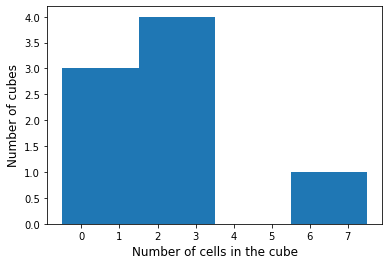

In [23]:
n_idx_list = []

for i in range(len(idx_list)):
    n_idx_list.append(idx_list[i].shape[0])

plt.figure()
plt.hist(n_idx_list, bins=np.arange(-0.5,8.5,1))
plt.xlabel("Number of cells in the cube", fontsize=12)
plt.ylabel("Number of cubes", fontsize=12)
plt.show()

## Figure S7 plots

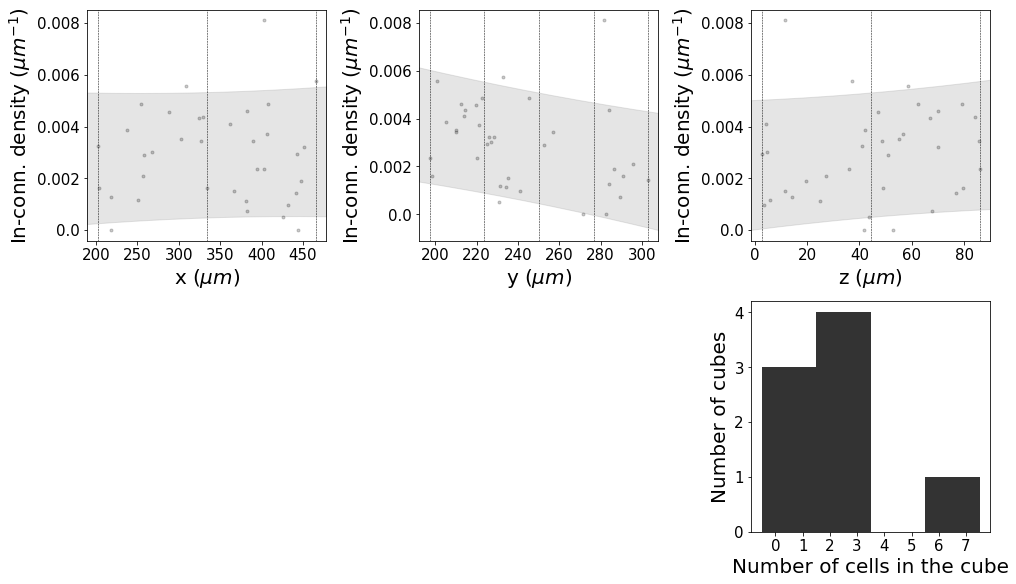

In [106]:
fig = plt.figure(figsize=(14,8), constrained_layout=True)
gs = fig.add_gridspec(2,3)

# Spatial distribution - x-axis 
ax1 = fig.add_subplot(gs[0,0])
plot_spatial_ax(ax1, xloc, inconn_density[tune_all_idx], nbins=3, xlab="x ($\mu m$)")

# Spatial distribution - y-axis
ax2 = fig.add_subplot(gs[0,1])
plot_spatial_ax(ax2, yloc, inconn_density[tune_all_idx], nbins=5, xlab="y ($\mu m$)")

# Spatial distribution - z-axis
ax3 = fig.add_subplot(gs[0,2])
plot_spatial_ax(ax3, zloc, inconn_density[tune_all_idx], nbins=3, xlab="z ($\mu m$)")

ax4 = fig.add_subplot(gs[1,2])
ax4.hist(n_idx_list, bins=np.arange(-0.5,8.5,1), color="k", alpha=0.8)
ax4.set_xlabel("Number of cells in the cube", fontsize=20, fontname="Helvetica")
ax4.set_ylabel("Number of cubes", fontsize=20, fontname="Helvetica")
ax4.set_xticks(np.arange(0,8,1))
ax4.set_xticklabels(np.arange(0,8,1), fontsize=15, fontname="Helvetica")
ax4.set_yticks(np.arange(0,5,1))
ax4.set_yticklabels(np.arange(0,5,1), fontsize=15, fontname="Helvetica")

plt.show()

In [48]:
palette = sns.color_palette("BuGn_r", 10)

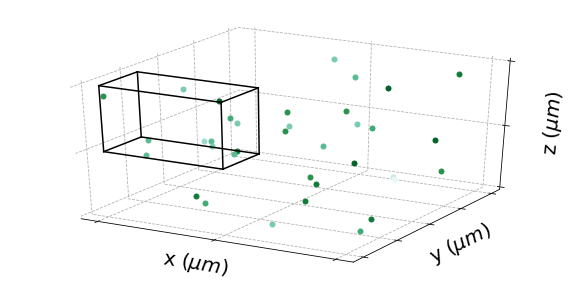

In [107]:
val = inconn_density[tune_all_idx]

i = 0
j = 0
k = 1

fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection="3d")

cbins = np.linspace(val.min()-0.0001, val.max()+0.0001, 11)
for c in range(cbins.shape[0]-1):
    valid = (val>=cbins[c])*(val<cbins[c+1])
    ax.plot(xloc[valid], yloc[valid], zloc[valid], ".", c=palette[c], markersize=10)

draw_cube(ax, (xbins[i],xbins[i+1]), (ybins[j], ybins[j+1]), (zbins[k], zbins[k+1]))

ax.w_xaxis.set_pane_color((1,1,1,0))
ax.w_yaxis.set_pane_color((1,1,1,0))
ax.w_zaxis.set_pane_color((1,1,1,0))
ax.set_xticks(xbins)
ax.set_xticklabels([])
ax.set_yticks(ybins)
ax.set_yticklabels([])
ax.set_zticks(zbins)
ax.set_zticklabels([])
plt.rcParams['grid.linestyle'] = "--"

ax.set_xlabel("x ($\mu m$)", fontsize=20, fontname="Helvetica")
ax.set_ylabel("y ($\mu m$)", fontsize=20, fontname="Helvetica")
ax.set_zlabel("z ($\mu m$)", fontsize=20, fontname="Helvetica")

# plt.savefig("figs7_shuffle_cartoon.svg")
plt.show()

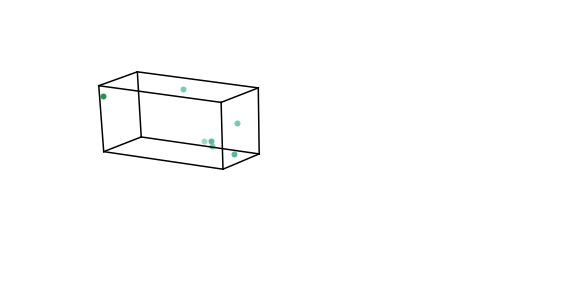

In [96]:
val = inconn_density[tune_all_idx]

i = 0
j = 0
k = 1

fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection="3d")

cbins = np.linspace(val.min()-0.0001, val.max()+0.0001, 11)
ax.plot(xloc, yloc, zloc, ".", c=palette[c], alpha=0, markersize=10)
for c in range(cbins.shape[0]-1):
    valid = (xloc>=xbins[i])*(xloc<xbins[i+1]) \
        *(yloc>=ybins[j])*(yloc<ybins[j+1]) \
        *(zloc>=zbins[k])*(zloc<zbins[k+1]) \
        *(val>=cbins[c])*(val<cbins[c+1])
    ax.plot(xloc[valid], yloc[valid], zloc[valid], ".", c=palette[c], markersize=10)

draw_cube(ax, (xbins[i],xbins[i+1]), (ybins[j], ybins[j+1]), (zbins[k], zbins[k+1]))

ax.w_xaxis.set_pane_color((1,1,1,0))
ax.w_yaxis.set_pane_color((1,1,1,0))
ax.w_zaxis.set_pane_color((1,1,1,0))
ax.set_xticks(xbins)
ax.set_xticklabels([])
ax.set_yticks(ybins)
ax.set_yticklabels([])
ax.set_zticks(zbins)
ax.set_zticklabels([])

ax.set_axis_off()

# plt.savefig("figs7_shuffle_excube.svg")
plt.show()